In [24]:
import pandas as pd

In [25]:
from powerNetworkSolver import PowerNetworkSolver
from powerNetwork import networkTransform, getGenerators, getBuses, getLines,getNumBuses, getNumLines
from powerNetwork import getUndGraph, kron_reduction, edge_removing
from disturbancesGnr import normaldisturbances
from violationChecking import globalcheck
import seaborn as sns; sns.set_theme()
#importing the function for multi-edge removal
from powerNetwork import multi_edge_removing


In [26]:
import matplotlib.pyplot as plt

In [27]:

import numpy as np
import copy
from numpy.linalg import inv 
import networkx as nx
from numpy.random import multivariate_normal
from disturbancesGnr import normaldisturbances
from scipy.integrate import odeint
from violationChecking import violationcheck,globalcheck,globalchecksubset
import time 
import math 
from functools import reduce




# 1. Test Case 39, complete network 

In [28]:
from pypower.api import case39

In [29]:
network39, subnetwork39 = networkTransform(case39())
df_lines39 = getLines(subnetwork39)
df_buses39 = getBuses(subnetwork39)

In [30]:
n39, ngnr39, unG39 = getUndGraph(df_buses39,df_lines39, network39)
A39, redL39, redA39  = kron_reduction(n39, ngnr39, unG39)
node_list =  np.arange(ngnr39)+1

#the previous adjacent matrix 
# redA39 = np.array([[0,2.484, 2.858, 2.372, 1.031, 0.222,2.13,13.057,3.676,7.834],
#               [2.484,0,10.494,1.781,0.774,0.166,1.599,1.473,0.903,5.885],
#               [2.858,10.494,0,2.522,1.096,0.236,2.264,1.729,1.144,4.772],
#               [2.372,1.781,2.522,0,17.136,0.535,5.14,1.699,1.755,1.367],
#               [1.031,0.774, 1.096,17.136,0 ,0.232, 2.235, 0.739, 0.763, 0.594],
#               [0.222,0.166,0.236,0.535,0.232,0,1.574, 0.159, 0.164, 0.128],
#               [2.13,1.599,2.264, 5.14, 2.235, 1.574, 0, 1.526, 1.576, 1.227],
#               [13.057,1.473,1.729, 1.699,0.739, 0.159, 1.526, 0, 4.283, 4.159],
#               [3.676, 0.903, 1.144, 1.755, 0.763, 0.164, 1.576, 4.283, 0, 1.37],
#               [7.834, 5.885, 4.772, 1.367, 0.594, 0.128, 1.227, 4.159, 1.37 ,0]])

# redA39 = np.ones((ngnr39,ngnr39))
np.fill_diagonal(redA39, 0)
 

In [31]:
K = 1
M = np.array([0.2228, 0.1607, 0.1899, 0.1517, 0.1379, 0.1846, 0.1401, 0.1289, 0.183, 2.6526])
D = np.array([0.0332,0.076,0.0862,0.0838,0.0674,0.0862,0.0743,0.0716,0.1101,0.1333])
# Ome = np.zeros(n)
pi = math.pi
t =  2
nn = 100
dt = np.linspace(0, t, nn+1)

sigma = 0.05
theta0 = np.zeros(ngnr39)
omega0 = np.zeros(ngnr39)
OMEGA = np.zeros(ngnr39)
model39 = PowerNetworkSolver(theta0,omega0,redA39, ngnr39, D,M,K,OMEGA)

In [32]:
from numpy.random import seed

In [33]:
#generate numerical tracks 
seed(100)
disturbances = normaldisturbances(ngnr39,1,sigma)
sol0 = np.pad(disturbances[0], (ngnr39,0), 'constant', constant_values=(0,0))
single_sol = model39.solkuramoto(sol0,dt)
sol_domega = model39.getDotOmega(single_sol[:,:ngnr39],single_sol[:,ngnr39:],nn)

Text(0.5, 1.0, 'Phase angles')

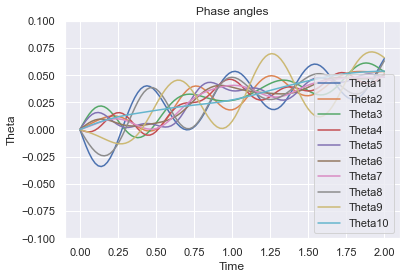

In [34]:
for i in range(ngnr39):
    theta = single_sol[:,i]
    plt.plot(dt, theta, "-", label="Theta"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Theta")    
plt.ylim(-0.1, 0.1)
plt.legend();
plt.title('Phase angles')

Text(0.5, 1.0, 'Natural rotation frequencies')

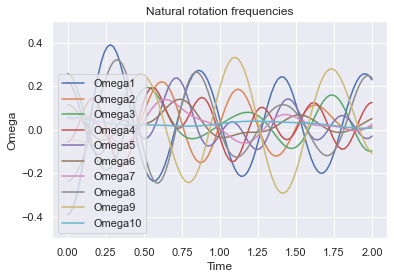

In [35]:
for i in range(ngnr39):
    omega = single_sol[:,ngnr39+i]  
    plt.plot(dt, omega, "-", label="Omega"+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega")
plt.ylim(-0.5, 0.5)
plt.legend();
plt.title('Natural rotation frequencies')

Text(0.5, 1.0, 'Change Rates of Natural rotation frequencies')

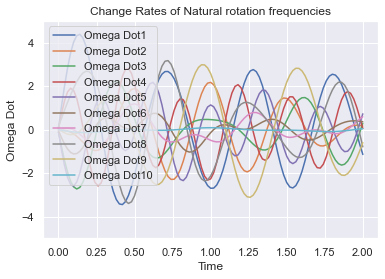

In [36]:
for i in range(ngnr39):
    domega = sol_domega[:,i]  
    plt.plot(dt, domega, "-", label="Omega Dot"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega Dot")
plt.ylim(-5, 5)
plt.legend();
plt.title('Change Rates of Natural rotation frequencies')

In [37]:
# simulation to calculate failure rates 
check_times = 100
KK =3000#repetition times  
thres = np.array([0.35,2])#thres1 is for omega, thres2 is for omega_dot
rates39 = model39.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [38]:
print(rates39['totaltime'])

1.1e+02sec


In [41]:
df39 = pd.DataFrame({'Node': node_list,'RoCoF': rates39['vcheck_omega'] , 'AFV': rates39['vcheck_theta'] ,'AV': rates39['vcheck_any']})
# print(df39.to_latex(index=False))

In [42]:
print(df39)

   Node     RoCoF       AFV        AV
0     1  0.675000  0.394333  0.707000
1     2  0.713667  0.444333  0.741333
2     3  0.680333  0.408000  0.719667
3     4  0.785000  0.525333  0.813333
4     5  0.838333  0.576667  0.859000
5     6  0.748667  0.499667  0.780333
6     7  0.807333  0.565333  0.829667
7     8  0.800000  0.524667  0.821000
8     9  0.569000  0.468667  0.632667
9    10  0.000000  0.122000  0.122000


network_test = multi_edge_removing(unG39, [[15,16],[20,34],[23,24]])

# 2. Test Case 39, incomplete networks

## 2.1 Removing (20, 34)

In [50]:
G3901 = edge_removing(unG39, [20,34])
A3901, redL3901, redA3901  = kron_reduction(n39, ngnr39, G3901)
model3901 = PowerNetworkSolver(theta0,omega0,redA3901, ngnr39,D,M,K,OMEGA)
rates3901 = model3901.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

The graph is not connected without edge (20, 34)


In [52]:
df3901 = pd.DataFrame({'Node': node_list,'RoCoF': rates3901['vcheck_omega'] , 'AFV': rates3901['vcheck_theta'] ,'AV': rates3901['vcheck_any']})
print(df3901.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 Node &     RoCoF &       AFV &        AV \\
\midrule
    1 &  0.671333 &  0.389333 &  0.707333 \\
    2 &  0.718667 &  0.452667 &  0.742667 \\
    3 &  0.683667 &  0.411667 &  0.712333 \\
    4 &  0.774667 &  0.506333 &  0.800667 \\
    5 &  0.824667 &  0.551667 &  0.846667 \\
    6 &  0.743000 &  0.484333 &  0.773000 \\
    7 &  0.802667 &  0.558000 &  0.824000 \\
    8 &  0.788333 &  0.502333 &  0.810333 \\
    9 &  0.543667 &  0.450667 &  0.606667 \\
   10 &  0.000000 &  0.104000 &  0.104000 \\
\bottomrule
\end{tabular}



## 2.2 Removing (15, 16)

In [63]:
G3902 = edge_removing(unG39, [15,16])
A3902, redL3902, redA3902  = kron_reduction(n39, ngnr39, G3902)
model3902 = PowerNetworkSolver(theta0,omega0,redA3902, ngnr39, D,M,K,OMEGA)
rates3902 = model3902.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [66]:
# disturbances = normaldisturbances(ngnr39,1,sigma)
# sol0 = np.pad(disturbances[0], (ngnr39,0), 'constant', constant_values=(0,0))
single_sol = model3902.solkuramoto(sol0,dt)

Text(0.5, 1.0, 'Natural rotation frequencies')

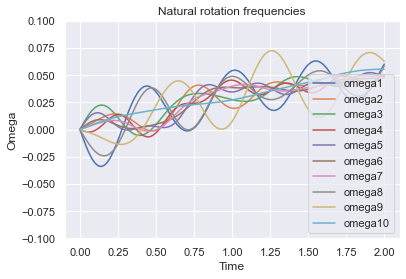

In [67]:
for i in range(ngnr39):
    theta = single_sol[:,i]
    plt.plot(dt, theta, "-", label="omega"+ str(i+1))

plt.xlabel("Time")
plt.ylabel("Omega")    
plt.ylim(-0.1, 0.1)
plt.legend();
plt.title('Natural rotation frequencies')

Text(0.5, 1.0, 'Derivatives of natural rotation frequencies')

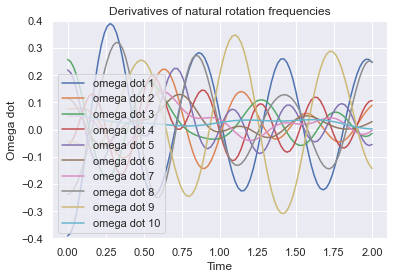

In [68]:
for i in range(ngnr39):
    omega = single_sol[:,ngnr39+i]  
    plt.plot(dt, omega, "-", label="omega dot "+ str(i+1))


plt.xlabel("Time")

plt.ylabel("Omega dot")
plt.ylim(-0.4, 0.4)
plt.legend();
plt.title('Derivatives of natural rotation frequencies')

In [69]:
df3902 = pd.DataFrame({'Node': node_list,'RoCoF': rates3902['vcheck_omega'] , 'AFV': rates3902['vcheck_theta'] ,'AV': rates3902['vcheck_any']})
# print(df3902.to_latex(index=False))

## 2.3 Removing (23, 24)

In [70]:
G3903 = edge_removing(unG39, [23,24])
A3903, redL3903, redA3903  = kron_reduction(n39, ngnr39, G3903)
model3903 = PowerNetworkSolver(theta0,omega0,redA3903, ngnr39, D,M,K,OMEGA)
rates3903 = model3903.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [71]:
df3903 = pd.DataFrame({'Node': node_list,'RoCoF': rates3903['vcheck_omega'] , 'AFV': rates3903['vcheck_theta'] ,'AV': rates3903['vcheck_any']})
# print(df3903.to_latex(index=False))

In [72]:
pd.options.display.float_format = '{:,.3f}'.format
df39.head()

,Node,RoCoF,AFV,AV
0,1,0.675,0.394,0.707
1,2,0.714,0.444,0.741
2,3,0.680,0.408,0.720
3,4,0.785,0.525,0.813
4,5,0.838,0.577,0.859


In [73]:
df39_merged = [df39,df3901,df3902,df3903]
df39merged = reduce(lambda  left,right: pd.merge(left,right,on=['Node'],
                                            how='outer'), df39_merged)
df39merged = df39merged.append(df39merged.mean(axis = 0), ignore_index=True)
print(df39merged.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrrr}
\toprule
  Node &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y \\
\midrule
 1.000 &    0.675 &  0.394 & 0.707 &    0.671 &  0.389 & 0.707 &    0.670 &  0.389 & 0.707 &    0.677 &  0.395 & 0.714 \\
 2.000 &    0.714 &  0.444 & 0.741 &    0.719 &  0.453 & 0.743 &    0.691 &  0.443 & 0.719 &    0.735 &  0.448 & 0.763 \\
 3.000 &    0.680 &  0.408 & 0.720 &    0.684 &  0.412 & 0.712 &    0.659 &  0.422 & 0.690 &    0.710 &  0.413 & 0.745 \\
 4.000 &    0.785 &  0.525 & 0.813 &    0.775 &  0.506 & 0.801 &    0.762 &  0.547 & 0.801 &    0.743 &  0.500 & 0.776 \\
 5.000 &    0.838 &  0.577 & 0.859 &    0.825 &  0.552 & 0.847 &    0.821 &  0.598 & 0.850 &    0.783 &  0.541 & 0.810 \\
 6.000 &    0.749 &  0.500 & 0.780 &    0.743 &  0.484 & 0.773 &    0.736 &  0.504 & 0.777 &    0.720 &  0.518 & 0.764 \\
 7.000 &    0.807 &  0.565 & 0.830 &    0.803 &  0.558 & 0.824 &    0.798 &  0.579 & 

## 2.4 Removing [4, 5],[15, 16]

In [75]:
G3904 = multi_edge_removing(unG39, ([4,5],[15,16]))
A3904, redL3904, redA3904  = kron_reduction(n39, ngnr39, G3904)
model3904 = PowerNetworkSolver(theta0,omega0,redA3904, ngnr39, D,M,K,OMEGA)
rates3904 = model3904.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

[4, 5]
[15, 16]


In [76]:
df3904 = pd.DataFrame({'Node': node_list,'RoCoF': rates3904['vcheck_omega'] , 'AFV': rates3904['vcheck_theta'] ,'AV': rates3904['vcheck_any']})
# print(df3901.to_latex(index=False))

In [77]:
print(df3904.head())

   Node  RoCoF   AFV    AV
0     1  0.677 0.384 0.707
1     2  0.699 0.476 0.730
2     3  0.648 0.432 0.682
3     4  0.782 0.546 0.824
4     5  0.828 0.589 0.859


In [78]:
df3904

,Node,RoCoF,AFV,AV
0,1,0.677,0.384,0.707
1,2,0.699,0.476,0.730
2,3,0.648,0.432,0.682
3,4,0.782,0.546,0.824
4,5,0.828,0.589,0.859
5,6,0.753,0.515,0.788
6,7,0.806,0.577,0.834
7,8,0.795,0.515,0.815
8,9,0.529,0.446,0.600
9,10,0.000,0.124,0.124


## 2.5 Removing [4, 5],[15, 16],[4, 14]

In [79]:
G3905 = multi_edge_removing(unG39, ([4,5],[15,16],[4,14]))
A3905, redL3905, redA3905  = kron_reduction(n39, ngnr39, G3905)
model3905 = PowerNetworkSolver(theta0,omega0,redA3905, ngnr39, D,M,K,OMEGA)
rates3905 = model3905.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

[4, 5]
[15, 16]
[4, 14]


In [80]:
df3905 = pd.DataFrame({'Node': node_list,'RoCoF': rates3905['vcheck_omega'] , 'AFV': rates3905['vcheck_theta'] ,'AV': rates3905['vcheck_any']})

In [81]:
df39_merged02 = [df3904,df3905]
df39merged02 = reduce(lambda  left,right: pd.merge(left,right,on=['Node'],
                                            how='outer'), df39_merged02)
df39merged02 = df39merged02.append(df39merged02.mean(axis = 0), ignore_index=True)
print(df39merged02.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
  Node &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y \\
\midrule
 1.000 &    0.677 &  0.384 & 0.707 &    0.645 &  0.401 & 0.694 \\
 2.000 &    0.699 &  0.476 & 0.730 &    0.666 &  0.527 & 0.708 \\
 3.000 &    0.648 &  0.432 & 0.682 &    0.611 &  0.491 & 0.653 \\
 4.000 &    0.782 &  0.546 & 0.824 &    0.741 &  0.510 & 0.787 \\
 5.000 &    0.828 &  0.589 & 0.859 &    0.792 &  0.549 & 0.831 \\
 6.000 &    0.753 &  0.515 & 0.788 &    0.693 &  0.473 & 0.755 \\
 7.000 &    0.806 &  0.577 & 0.834 &    0.757 &  0.544 & 0.803 \\
 8.000 &    0.795 &  0.515 & 0.815 &    0.777 &  0.529 & 0.808 \\
 9.000 &    0.529 &  0.446 & 0.600 &    0.515 &  0.446 & 0.593 \\
10.000 &    0.000 &  0.124 & 0.124 &    0.000 &  0.114 & 0.114 \\
 5.500 &    0.652 &  0.460 & 0.696 &    0.620 &  0.458 & 0.675 \\
\bottomrule
\end{tabular}



## 2.6 Removing [4, 5]

In [83]:
G3906 = edge_removing(unG39,[4,5])
A3906, redL3906, redA3906  = kron_reduction(n39, ngnr39, G3906)
model3906 = PowerNetworkSolver(theta0,omega0,redA3906, ngnr39, D,M,K,OMEGA)
rates3906 = model3906.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [84]:
df3906 = pd.DataFrame({'Node': node_list,'RoCoF': rates3906['vcheck_omega'] , 'AFV': rates3906['vcheck_theta'] ,'AV': rates3906['vcheck_any']})

## 2.7 Removing [4, 14]

In [85]:
G3907 = edge_removing(unG39,[4,14])
A3907, redL3907, redA3907  = kron_reduction(n39, ngnr39, G3907)
model3907 = PowerNetworkSolver(theta0,omega0,redA3907, ngnr39, D,M,K,OMEGA)
rates3907 = model3907.Simulation(KK, check_times, sigma, thres, t, nn, normaldisturbances)

In [86]:
df3907 = pd.DataFrame({'Node': node_list,'RoCoF': rates3907['vcheck_omega'] , 'AFV': rates3907['vcheck_theta'] ,'AV': rates3907['vcheck_any']})

In [ ]:
print(np.shape(np.reshape(np.ones(10),(1,10))*np.reshape(np.ones(10),(1,10))))
print(np.shape(np.ones(10)*np.ones(10)))

In [88]:
df39_merged02 = [df3906,df3907,df3904,df3905]
df39merged02 = reduce(lambda  left,right: pd.merge(left,right,on=['Node'],
                                            how='outer'), df39_merged02)
df39merged02 = df39merged02.append(df39merged02.mean(axis = 0), ignore_index=True)
print(df39merged02.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrrr}
\toprule
  Node &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y &  RoCoF\_x &  AFV\_x &  AV\_x &  RoCoF\_y &  AFV\_y &  AV\_y \\
\midrule
 1.000 &    0.669 &  0.390 & 0.707 &    0.676 &  0.375 & 0.710 &    0.677 &  0.384 & 0.707 &    0.645 &  0.401 & 0.694 \\
 2.000 &    0.678 &  0.452 & 0.711 &    0.688 &  0.436 & 0.722 &    0.699 &  0.476 & 0.730 &    0.666 &  0.527 & 0.708 \\
 3.000 &    0.644 &  0.411 & 0.680 &    0.681 &  0.425 & 0.714 &    0.648 &  0.432 & 0.682 &    0.611 &  0.491 & 0.653 \\
 4.000 &    0.765 &  0.524 & 0.798 &    0.783 &  0.529 & 0.812 &    0.782 &  0.546 & 0.824 &    0.741 &  0.510 & 0.787 \\
 5.000 &    0.819 &  0.571 & 0.843 &    0.838 &  0.582 & 0.859 &    0.828 &  0.589 & 0.859 &    0.792 &  0.549 & 0.831 \\
 6.000 &    0.748 &  0.503 & 0.781 &    0.744 &  0.494 & 0.777 &    0.753 &  0.515 & 0.788 &    0.693 &  0.473 & 0.755 \\
 7.000 &    0.810 &  0.580 & 0.835 &    0.801 &  0.569 & 0.826 &    0.806 &  0.577 & 